In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, plot_precision_recall_curve
from sklearn.model_selection import train_test_split

In [2]:
abo_path = 'D:/Users/masoodw/ML_FINANCE/asigmo/github/asigmo/data/telcom_churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
p_df_raw = pd.read_csv(abo_path, sep=',', encoding="UTF-8")

In [3]:
p_df_raw.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [4]:
p_df_raw.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Transform the data: make every column into number and scale the values of each column

In [7]:
df_y = p_df_raw['Churn']
df_y = pd.DataFrame(LabelEncoder().fit_transform(df_y))
df_y = df_y.reset_index(drop=True)

df_X_raw = p_df_raw.drop(['customerID', 'Churn'], axis=1)
#df_X_raw = p_df_raw_train.drop(['Name'], axis=1)

columns=df_X_raw.columns
for f in df_X_raw.columns:
    if df_X_raw[f].dtype == 'object':
        df_X_raw[f] = LabelEncoder().fit_transform(list(df_X_raw[f]))        

In [8]:
scaler = PowerTransformer()
scaled_df = scaler.fit_transform(df_X_raw)
df_X = pd.DataFrame(scaled_df, columns=columns)
df_X = df_X.reset_index(drop=True)

In [9]:
class_labels = np.unique(df_y)
class_weights = compute_class_weight('balanced', class_labels, df_y)
class_weights = dict(zip(class_labels, class_weights))

c:\programdata\anaconda3\envs\asigmo\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=      0
0     0
1     0
2     1
3     0
4     1
...  ..
7038  0
7039  0
7040  0
7041  1
7042  0

[7043 rows x 1 columns] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
c:\programdata\anaconda3\envs\asigmo\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [10]:
class_weights

{0: 0.6806146115191342, 1: 1.8841626538255751}

In [11]:
df_X.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y)

In [58]:
categorical_feature=['gender', 'SeniorCitizen', 'Partner', 'Dependent',
                     'PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity', 'DeviceProtection', 'TechSupport',
                     'StreamingTV', 'StreamingMovies','Contract', 'PaperlessBilling', 'PaymentMethod' ]

train_data = lgb.Dataset(X_train, label=y_train) #categorical_feature=categorical_feature)

### LightGM parameters

In [93]:
params = {}
#params['max_bin'] = 10
params['learning_rate'] = 0.1 # shrinkage_rate
#params['boosting_type'] = 'gbdt'
params['metric'] = 'auc'          # or 'mae'
params['sub_feature'] = 0.50      # feature_fraction 
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['verbose'] = 0

### training with CV

In [94]:
eval_hist = lgb.cv(
    params = params, train_set = train_data,
    num_boost_round=100, 
    nfold=3,
    stratified=True,
    shuffle=True,
    #metrics='auc', 
    fobj=None, ### explore later in detail
    feval=None, ### explore later in detail
    init_model=None,
    feature_name='auto',
    #early_stopping_rounds=5,
    fpreproc=None,
    verbose_eval=20,
    show_stdv=True,
    seed=0,
    callbacks=None, ### explore later in detail
    eval_train_metric=False,
    return_cvbooster=False
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score 0.261005
[LightGBM] [Info] Start training from score 0.261005
[LightGBM] [Info] Start training from score 0.261215
[20]	cv_agg's auc: 0.837145 + 0.00911264
[40]	cv_agg's auc: 0.835552 + 0.00888605
[60]	cv_agg's auc: 0.833809 + 0.00957177
[80]	cv_agg's auc: 0.830021 + 0.0110321
[100]	cv_agg's auc: 0.828182 + 0.0111303


In [97]:
# Display results
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(eval_hist['auc-mean']))
print('Best CV score:', eval_hist['auc-mean'][-1])

Current parameters:
 {'learning_rate': 0.1, 'metric': 'auc', 'sub_feature': 0.5, 'bagging_fraction': 0.85, 'bagging_freq': 40, 'verbose': 0}

Best num_boost_round: 100
Best CV score: 0.828182307962502


In [98]:
bst = lgb.train(params, train_data, 100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


### Predicting on test data

In [100]:
clf_test_pred = bst.predict(X_test)

#### convert prob to binary classes

In [103]:
clf_test_pred

array([0.18542699, 0.58453944, 0.44878349, ..., 0.04397342, 0.49783575,
       0.71412778])

In [101]:
auc_test = roc_auc_score(y_test, clf_test_pred)
test_f1 = round(f1_score(y_test, clf_test_pred), 8)*100
print('\nAUROC:',auc_test, ", F1 score:", test_f1)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [161]:
fpr, tpr, threshold = roc_curve(y_test, clf_test_pred)

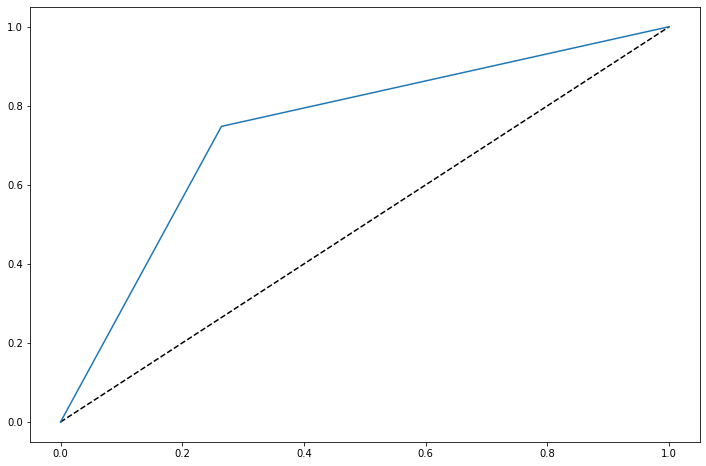

In [162]:
fig = plt.figure(figsize=(12,8)) 
ax = fig.add_subplot(1,1,1)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr)

In [163]:
 print('Accuracy')
print(accuracy_score(y_test, clf_test_pred))
print('Confusion Matrix')
print(confusion_matrix(y_test, clf_test_pred))
print('Confusion Report')
print(classification_report(y_test, clf_test_pred))

Accuracy
0.7387847813742192
Confusion Matrix
[[960 345]
 [115 341]]
Confusion Report
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1305
           1       0.50      0.75      0.60       456

    accuracy                           0.74      1761
   macro avg       0.70      0.74      0.70      1761
weighted avg       0.79      0.74      0.75      1761



### Rpeat the above stats for test data

### saving/loading the model

In [ ]:
joblib.dump(clf, 'RF_F1_.pkl')

In [ ]:
clf_pickle = joblib.load('SVM_test.pkl')